# Group E - Investing in Peer2Peer Lending (Team Assignment 2)

Team members: Christopher Arraya, Isaac Sparrow, Leonard Yang, Nicholas Wong, Lei Zhang, Jose Camacho

In [1]:
#0a Mount Drive
from google.colab import drive
drive.mount('/content/gdrive')

#0b Change into directory where data files are
# %cd /content/gdrive/MyDrive/project2
#%cd /content/gdrive/MyDrive/488/Team-Assignment-2
%cd /content/gdrive/MyDrive/UNC 23-24/COMP 488/Local Team Assignment 2

#0c show files in current directory
!ls # view the files in the current directory of the notebook environment

Mounted at /content/gdrive
/content/gdrive/MyDrive/UNC 23-24/COMP 488/Local Team Assignment 2
accepted_2007_to_2018Q4.csv  lending.ipynb  rejected_2007_to_2018Q4.csv


#Import Libraries

In [3]:
# Working with dfs
import pandas as pd
import numpy as np
from numpy import arange

# Visuals
import seaborn as sns
import matplotlib.pyplot as plt

# Modeling
import IPython
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

# Model Accuracy
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score


## Data

###Load preprocessed datasets.

In this first section, we work with two csv files (accepted and rejected loans) that are truncated versions of the original dataset containing \~30 million records. Through data manipulation in excel, 151 features in the accepted loans dataset were trimmed to 16 features. This process of feature selection was done using our domain expertise in evaluating the features most relevant to predicting loan approval. The result of this process of data preprocessing in excel is an accepted dataset with \~1 million observations and a rejected dataset with
\~1 million observations. These datasets are then stacked using their 4 common features (`dti`, `emp_length`, `purpose`, `loan_amnt`) as a compound key.

In [4]:
df1 = pd.read_csv("accepted_2007_to_2018Q4.csv")
df2 = pd.read_csv("rejected_2007_to_2018Q4.csv")

<ipython-input-4-02ebe35ce4de>:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv("accepted_2007_to_2018Q4.csv")


In [5]:
df1.purpose.value_counts()

debt_consolidation    594793
credit_card           242358
home_improvement       72312
other                  62426
major_purchase         22838
medical                12668
car                    10506
small_business          9767
vacation                7416
moving                  7169
house                   5706
renewable_energy         593
wedding                   10
educational                1
Name: purpose, dtype: int64

In [6]:
df2.purpose.value_counts()

debt_consolidation                         378590
other                                      130802
credit_card                                 86016
home_improvement                            58598
car                                         53376
                                            ...  
Consilidate Credit Card Debt                    1
Back on our feet                                1
Credit card free                                1
UHURU PUBLISHING LAUNCHES                       1
LC INVESTMENT III: REVENGE OF THE NOTES         1
Name: purpose, Length: 61349, dtype: int64

In [7]:
# Function to categorize employment length
def categorize_emp_length(emp_length):
    if emp_length == '10+ years':
        return '10+ years'
    elif emp_length == '< 1 year':
        return '< 1 year'
    else:
        return '1-10 years'

# Apply the function to the 'emp_length' column
df1['emp_length'] = df1['emp_length'].apply(categorize_emp_length)
df2['emp_length'] = df2['emp_length'].apply(categorize_emp_length)

# Convert 'emp_length' to a categorical type
df1['emp_length'] = pd.Categorical(df1['emp_length'], categories=['< 1 year', '1-10 years', '10+ years'])
df2['emp_length'] = pd.Categorical(df1['emp_length'], categories=['< 1 year', '1-10 years', '10+ years'])

# Display the first few rows of the dataframe to verify changes
df2.head()

,loan_amnt,Application Date,purpose,Risk_Score,dti,Zip Code,State,emp_length
0,1000.0,5/26/07,Wedding Covered but No Honeymoon,693.0,0.10,481xx,NM,10+ years
1,1000.0,5/26/07,Consolidating Debt,703.0,0.10,010xx,MA,10+ years
2,11000.0,5/27/07,Want to consolidate my debt,715.0,0.10,212xx,MD,10+ years
3,6000.0,5/27/07,waksman,698.0,0.39,017xx,MA,10+ years
4,1500.0,5/27/07,mdrigo,509.0,0.09,209xx,MD,1-10 years


In [8]:
# prompt: bin the purpose variable, debt_consolidation, credit_card as its own category, the rest all labeled as other

df1['purpose'] = df1['purpose'].apply(lambda x: 'debt_consolidation' if x=='debt_consolidation' else 'credit_card' if x=='credit_card' else 'other')
df2['purpose'] = df2['purpose'].apply(lambda x: 'debt_consolidation' if x=='debt_consolidation' else 'credit_card' if x=='credit_card' else 'other')


In [9]:
df1.head()

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,loan_status,purpose,dti,delinq_2yrs,fico_range_low,fico_range_high,total_pymnt
0,68407277,3600.0,3600.0,36 months,13.99,123.03,C,10+ years,MORTGAGE,Fully Paid,debt_consolidation,5.91,0.0,675.0,679.0,4421.723917
1,68355089,24700.0,24700.0,36 months,11.99,820.28,C,10+ years,MORTGAGE,Fully Paid,other,16.06,1.0,715.0,719.0,25679.660000
2,68341763,20000.0,20000.0,60 months,10.78,432.66,B,10+ years,MORTGAGE,Fully Paid,other,10.78,0.0,695.0,699.0,22705.924290
3,66310712,35000.0,35000.0,60 months,14.85,829.90,C,10+ years,MORTGAGE,Current,debt_consolidation,17.06,0.0,785.0,789.0,31464.010000
4,68476807,10400.0,10400.0,60 months,22.45,289.91,F,1-10 years,MORTGAGE,Fully Paid,other,25.37,1.0,695.0,699.0,11740.500000


In [10]:
# prompt: Identify the common features in both datasets

common_features = set(df1.columns) & set(df2.columns)
print(common_features)


{'purpose', 'loan_amnt', 'dti', 'emp_length'}


In [11]:
# Define the common features
common_features = ['purpose', 'emp_length', 'dti', 'loan_amnt']

# Filter both DataFrames for the common features
df1_filtered = df1[common_features].copy()
df2_filtered = df2[common_features].copy()

# Add the new 'status' column
df1_filtered['status'] = 'accepted'
df2_filtered['status'] = 'rejected'

# Concatenate the DataFrames
df_stacked = pd.concat([df1_filtered, df2_filtered], axis=0).reset_index(drop=True)

In [12]:
df_stacked.head()

,purpose,emp_length,dti,loan_amnt,status
0,debt_consolidation,10+ years,5.91,3600.0,accepted
1,other,10+ years,16.06,24700.0,accepted
2,other,10+ years,10.78,20000.0,accepted
3,debt_consolidation,10+ years,17.06,35000.0,accepted
4,other,1-10 years,25.37,10400.0,accepted


In [13]:
# Check for class imbalance
df_stacked.status.value_counts()

accepted    1048575
rejected    1048575
Name: status, dtype: int64

In [14]:
# Check missing values
df_stacked.isnull().sum()

purpose         0
emp_length      0
dti           868
loan_amnt      12
status          0
dtype: int64

In [15]:
# prompt: drop row with missing values
df_stacked = df_stacked.dropna()

In [16]:
# prompt: create function to drop the outliers

def remove_outliers(df, features):
  for feature in features:
    # Calculate the interquartile range
    IQR = df[feature].quantile(0.75) - df[feature].quantile(0.25)

    # Calculate the upper and lower bounds
    upper_bound = df[feature].quantile(0.75) + 1.5 * IQR
    lower_bound = df[feature].quantile(0.25) - 1.5 * IQR

    # Filter the data based on the bounds
    df = df[df[feature] <= upper_bound]
    df = df[df[feature] >= lower_bound]

  return df

features = ['dti', 'loan_amnt']
df_filtered = remove_outliers(df_stacked, features)
len(df_filtered)


2068846

In [17]:
# prompt: standardize the numeric features on the same scale

numeric_features = ['dti', 'loan_amnt']

# Standardize the numeric features
for feature in numeric_features:
  df_filtered[feature] = (df_filtered[feature] - df_filtered[feature].mean()) / df_filtered[feature].std()

In [18]:
# prompt: one hot encoding for the cat features

# One-hot encode the categorical features
categorical_features = ['purpose', 'emp_length']

df_encoded = pd.get_dummies(df_filtered, columns=categorical_features)

In [19]:
# prompt: one hot encoding for 'status', 0 as rejected, 1 as accepted

df_encoded['status'] = df_encoded['status'].apply(lambda x: 1 if x == 'accepted' else 0)


## Exploratory Data Analysis

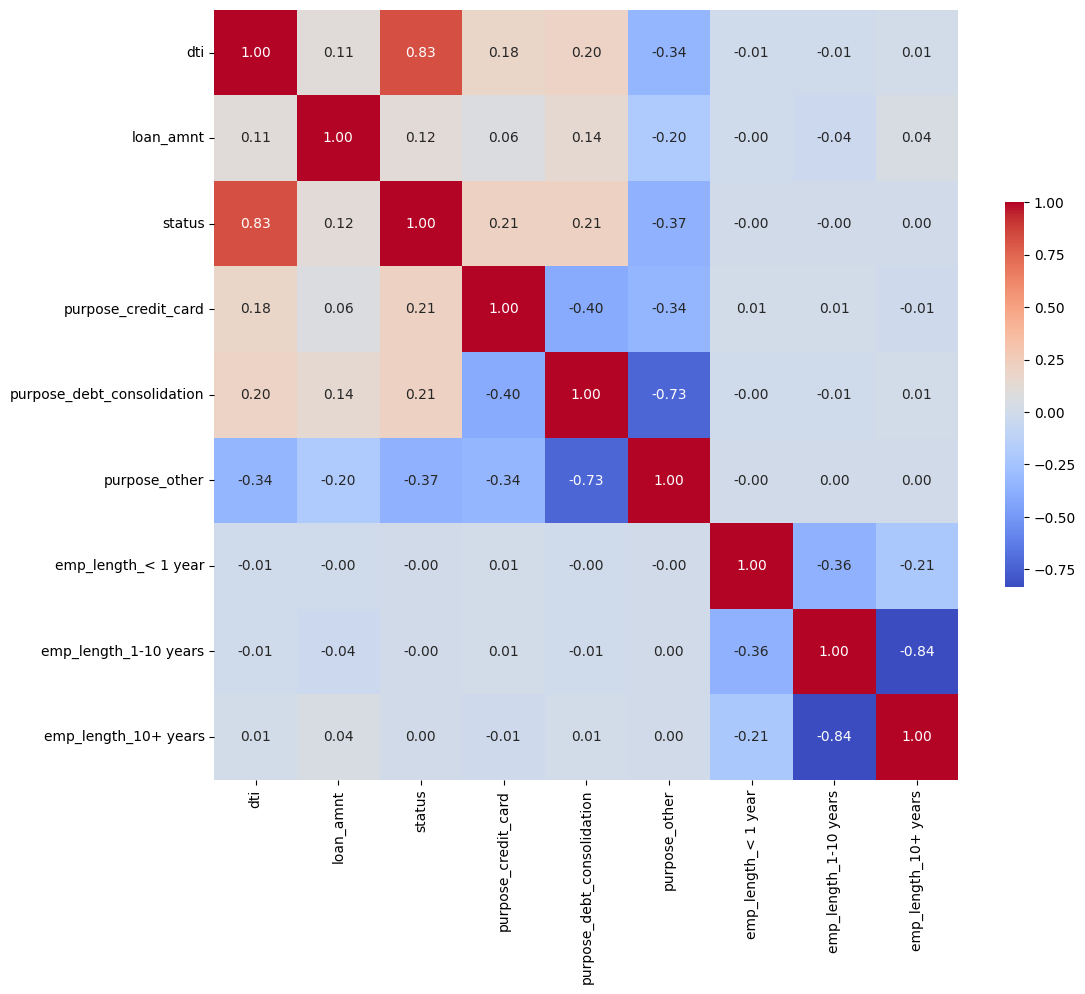

In [20]:
# prompt: print a heatmap for correlated variables


# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(df_encoded.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={"shrink": .5})

# Optionally, adjust the font size of the annotations if they are still overlapping
sns.set(font_scale=0.8)

plt.show()


We note an unusually high correlation between loan status and debt-to-income ratio (DTI). We visualize this relationship with a violin plot.

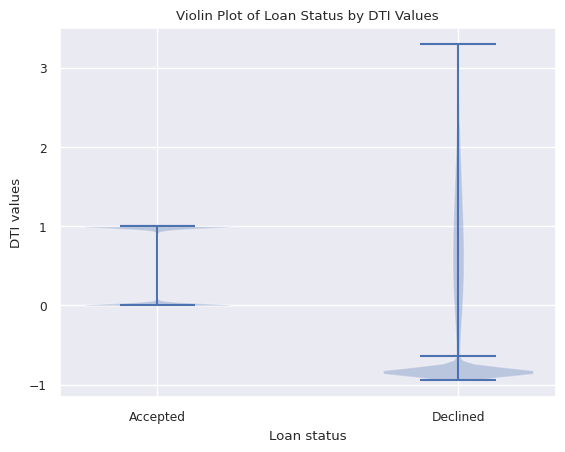

In [21]:
data = [df_encoded['status'], df_encoded['dti']]

plt.violinplot(data, showmedians = True)

plt.title('Violin Plot of Loan Status by DTI Values')
plt.xticks([1,2], ['Accepted', 'Declined'])
plt.xlabel('Loan status')
plt.ylabel('DTI values')

plt.show()

## Logistic Regression

In this section, we implement a logistic regression model for loan status prediction on our preprocessed dataset.

In [22]:
# prompt: split train test set, set 'status'' as target, the rest as features, perform logistic regression, train on a 3-fold cv, fit on the test set, get the accuracy and auc score for the test set

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_encoded.drop('status', axis=1), df_encoded['status'], test_size=0.2, random_state=42)

# Define the target and features
target = 'status'
features = list(X_train.columns)

# Instantiate the LogisticRegression model
model = LogisticRegression(random_state=42)

# Perform 3-fold cross-validation
scores = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy')
print("Cross-validation accuracy scores:", scores)

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy and AUC score for the test set
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

print("Test set accuracy:", accuracy)
print("Test set AUC score:", auc)


Cross-validation accuracy scores: [0.98542484 0.98526533 0.98546472]
Test set accuracy: 0.9849892452328588
Test set AUC score: 0.9850272754421979


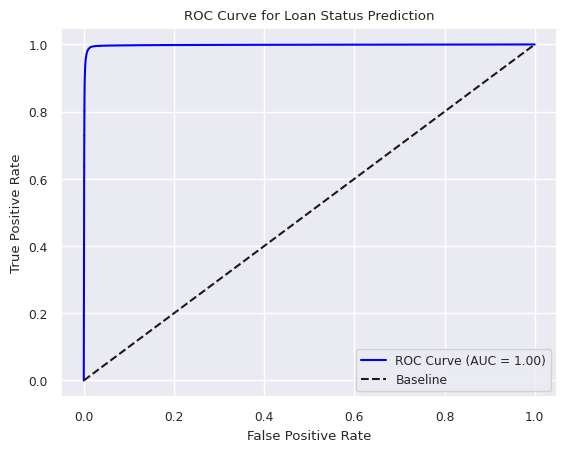

In [23]:
# prompt: draw a roc auc chart

# Get predicted probabilities for the test set
y_prob = model.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % auc, color='blue')  # Specify color for clarity
plt.plot([0, 1], [0, 1], 'k--', label='Baseline')  # Label for the dashed line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Loan Status Prediction')
plt.legend(loc='lower right')
plt.show()



In [24]:
# prompt: which feature is most important, find out from the coefficient, and make it into a  fancy dataframe

# Get the coefficients and feature names
coefficients = model.coef_.tolist()[0]
feature_names = X_train.columns

# Create a DataFrame with coefficients and feature names
df_coef = pd.DataFrame({'coefficient': coefficients, 'feature': feature_names})

# Sort the DataFrame by coefficient in descending order
df_coef = df_coef.sort_values(by='coefficient', ascending=False)

# Display the top 5 features with the highest coefficients
df_coef.head(5)


,coefficient,feature
0,15.200904,dti
2,0.292738,purpose_credit_card
5,0.161685,emp_length_< 1 year
1,0.083459,loan_amnt
6,0.002915,emp_length_1-10 years


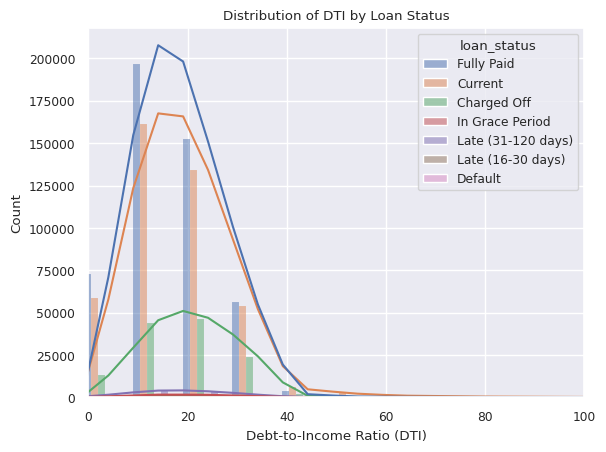

In [25]:
# Plotting the distribution of DTI for charged-off and fully paid loans
sns.histplot(data=df1, x='dti', hue='loan_status', bins=100, kde=True, multiple='dodge')
plt.xlabel('Debt-to-Income Ratio (DTI)')
plt.ylabel('Count')
plt.title('Distribution of DTI by Loan Status')
plt.xlim(0, 100)
plt.show()

For predicting loan status, debt-to-income ratio (DTI) is far and away the feature of most significance, evidenced by its high coefficient in logistic regression. Moreover, as evidenced by the violin plot in our EDA and the above density plot, if we take out of consideration current loans (as these do not have the potential to default), we can see a bimodal distribution of charged off and fully paid loans that can be clustered almost perfectly by DTI.

### Confusion Matrix and Classification Report for Logistic Regression

              precision    recall  f1-score   support

           0       0.98      0.99      0.99    205883
           1       0.99      0.98      0.98    207887

    accuracy                           0.98    413770
   macro avg       0.99      0.99      0.98    413770
weighted avg       0.99      0.98      0.98    413770



Text(0.5, 21.049999999999997, 'Predicted')

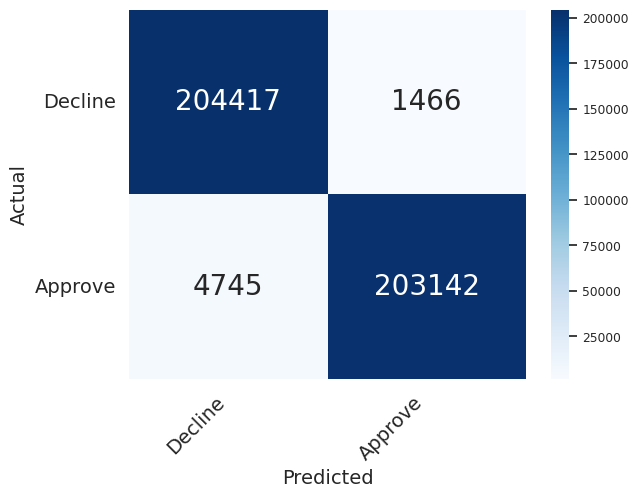

In [26]:
# generate classification report
print(classification_report(y_test, y_pred))

# generate confusion matrix
con_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix_df = pd.DataFrame(con_matrix, ('Decline', 'Approve'), ('Decline', 'Approve'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d", cmap="Blues")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)

Our model achieves a high level of accuracy, with significantly more false negative predictions than false positives. This results in a better precision metric and worse recall - which is desirable for investors as false positives are substantially more costly in P2P lending. Hence, we prioritize better precision in implementing our classification model.

However, given the fact that we are using a fraction of the original data of 30 million observations to build our logistic regression model and given the unusually high accuracy/AUC scores, we have concerns that we may be overfitting our logistic regression to this sample. As a result, below, we experiment with regularized logistic regression to curb these concerns and to attempt to better generalize out of sample.


## Regularized Logistic Regresson (L2 Penalty) to Classify Loan Status

In this section, we implement a logistic regression model with a ridge penalty to control for overfitting and reduce variance through shrinking coefficients of related predictors. First, we tune the λ regularization hyperparameter (C in SKlearn - inverse of regularization strength).

In [27]:
# prompt: cross-validate logistic regression for optimal ridge penalty

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_encoded.drop('status', axis=1), df_encoded['status'], test_size=0.2, random_state=42)

# Standardize features for ridge penalty
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# Define the model
log_ridge = LogisticRegression(penalty='l2', solver='liblinear')

# Hyperparameter grid
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 200, 300]}

# Initialize GridSearchCV with 5 fold CV for hyperparameter tuning
grid_search = GridSearchCV(log_ridge, param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Evaluate the results of our cross-validation
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

optimal_C = grid_search.best_params_['C']


Best parameters: {'C': 100}
Best cross-validation score: 0.9853970452425906


Now, with the C hyperparameter tuned, we fit a logistic regression with this cross-validated ridge penalty.

In [28]:
from sklearn.metrics import accuracy_score, roc_auc_score

# Define the model
log_ridge = LogisticRegression(penalty='l2', solver='liblinear', C = optimal_C)

# Fit the model
log_ridge.fit(X_train_scaled, y_train)

# Check coefs
print("Coefficients:", log_ridge.coef_)

# Make predictions on the test set
y_pred = log_ridge.predict(X_test_scaled)

# Calculate accuracy and AUC score for the test set
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

print("Test set accuracy:", accuracy)
print("Test set AUC score:", auc)

Coefficients: [[ 1.52278722e+01  8.38075890e-02  1.24389843e-01  5.89928781e-03
  -9.93381123e-02  5.70966154e-02  2.28098439e-02 -5.74655537e-02]]
Test set accuracy: 0.9849892452328588
Test set AUC score: 0.9850272520312012


Logistic regression classifier achieves comparable performance with the L2 penalty. For generalizing loan status prediction beyond our stacked dataframe, we recommend implementing the logistic regression model with a regularization penalty to control for overfitting as the penalty will prevent too much weight from being assigned to any single feature. In a reduced dataset such as ours, this penalty will likely allow the model to better generalize to out of sample data.

Now, we visualize the regularization pathway implemented with the above ridge
penalty to see how the different coefficients change with regularization strength.

### Visualization of regularization pathway with ridge penalty

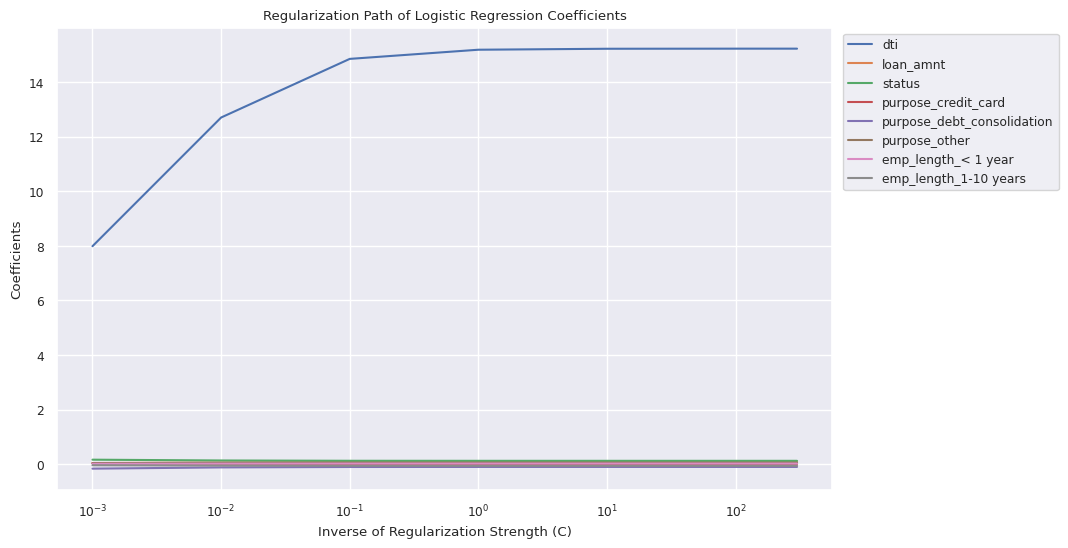

In [29]:
# Range of regularization strengths as per cross-validation above - C denotes inverse of regularization strength (smaller C -> higher penalty)
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 200, 300]

# Initialize a list to store the coefficients
coefficients = []

for C in C_values:
    logreg = LogisticRegression(penalty='l2', C=C, solver='liblinear', random_state=42)
    logreg.fit(X_train_scaled, y_train)
    coefficients.append(logreg.coef_[0])

# Convert the list of coefficients into a 2D numpy array
coefficients = np.array(coefficients)

# Plot the regularization path
plt.figure(figsize=(10, 6))
for i in range(coefficients.shape[1]):
    plt.plot(C_values, coefficients[:, i], label=df_encoded.columns[i])

plt.xscale('log')
plt.xlabel('Inverse of Regularization Strength (C)')
plt.ylabel('Coefficients')
plt.title('Regularization Path of Logistic Regression Coefficients')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.show()

## Primary Findings from Loan Status Prediction

In this section, we briefly emunerate our primary findings from the first section of our project involving loan status prediction before we proceed with our analysis on accepted loans.
1. Through our EDA, we find that debt-to-income ratio (DTI) is highly correlated with loan status with a correlation of 0.83.
2. Through relevant visualizations, we discover that observations can be clustered almost perfectly as accepted or rejected loans based solely on DTI.
3. Because of this phenomenon of well-separated data on a single feature (DTI), logistic regression achieves excellent predictive performance.
4. For out-of-sample loan status prediction, we recommend implementing a logistic regression model with a regularization penalty.
5. For our logistic regression model implemented with a ridge penalty, we note that at the optimal regularization strength, other features are shrunk even closer to 0 while DTI remains approximately the same in relation to the unpenalized logistic regression - further confirming the importance of DTI for loan status prediction. This is demonstrated above with our visualization for the regularization pathway and how coefficients vary with different regularization strengths.

## Analysis on accepted loans
##### The high accuracies of our models, with high reliance on Debt-To-Income ratios, suggest that Lending Club may have used a filtering process for accepting and denying loans based on this ratio. Additionally, not all accepted loans are successful and some default or are late. Therefore, we proceed to run predictive models on the accepted loan data alone.

In [30]:
accepted = pd.read_csv("accepted_2007_to_2018Q4.csv")

<ipython-input-30-ab34ca6b50d0>:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  accepted = pd.read_csv("accepted_2007_to_2018Q4.csv")


In [31]:
#sum(accepted['loan_status'] == 'Current')
#sum(accepted['loan_amnt'] != accepted['funded_amnt'])
#accepted['emp_length'].unique()

In [32]:
# prompt: Create a new dataframe from df1 that only includes entries where total_pymnt is less than loan_amnt

incomplete_loans = accepted[accepted['total_pymnt'] < accepted['loan_amnt']]

In [33]:
# prompt: shape of new_df1

incomplete_loans.shape

(502590, 16)

In [34]:
# prompt: Create a new df from incomplete loans where total pymnt is less than 50% of loan amnt

low_pymt_loans = incomplete_loans[incomplete_loans['total_pymnt'] < (incomplete_loans['loan_amnt'] * 0.5)]


In [35]:
# prompt: print head of low pymt loans

low_pymt_loans.head()


,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,loan_status,purpose,dti,delinq_2yrs,fico_range_low,fico_range_high,total_pymnt
31,68341789,24250.0,24250.0,60 months,24.24,701.01,F,4 years,MORTGAGE,Charged Off,debt_consolidation,20.84,0.0,660.0,664.0,4124.42
60,68584507,16000.0,16000.0,60 months,13.44,367.67,C,1 year,RENT,Charged Off,credit_card,9.60,0.0,670.0,674.0,4382.17
78,68466066,20200.0,20200.0,60 months,18.49,518.35,D,4 years,RENT,Charged Off,debt_consolidation,34.84,0.0,720.0,724.0,9278.43
79,68436934,23975.0,23975.0,60 months,19.89,633.73,E,10+ years,RENT,Charged Off,credit_card,33.20,0.0,685.0,689.0,3928.86
83,68376217,23100.0,23100.0,60 months,20.50,618.46,E,2 years,OWN,Charged Off,car,20.43,0.0,660.0,664.0,5305.12


In [36]:
# prompt: Shape of low_pmnt loans

low_pymt_loans.shape


(291733, 16)

In [37]:
# prompt: shape of accepted loans

accepted.shape


(1048575, 16)

In [38]:
# Find ratio of the amount of loans that are not fully paid

291733/1048575

0.2782185346780154

In [39]:
# prompt: Add a feature to the accepted loans df that is a ratio of funded amnt to total_pmnt

accepted['profit_ratio'] =  accepted['total_pymnt'] / accepted['funded_amnt']

print(accepted.head())

         id  loan_amnt  funded_amnt        term  int_rate  installment grade  \
0  68407277     3600.0       3600.0   36 months     13.99       123.03     C   
1  68355089    24700.0      24700.0   36 months     11.99       820.28     C   
2  68341763    20000.0      20000.0   60 months     10.78       432.66     B   
3  66310712    35000.0      35000.0   60 months     14.85       829.90     C   
4  68476807    10400.0      10400.0   60 months     22.45       289.91     F   

  emp_length home_ownership loan_status             purpose    dti  \
0  10+ years       MORTGAGE  Fully Paid  debt_consolidation   5.91   
1  10+ years       MORTGAGE  Fully Paid      small_business  16.06   
2  10+ years       MORTGAGE  Fully Paid    home_improvement  10.78   
3  10+ years       MORTGAGE     Current  debt_consolidation  17.06   
4    3 years       MORTGAGE  Fully Paid      major_purchase  25.37   

   delinq_2yrs  fico_range_low  fico_range_high   total_pymnt  profit_ratio  
0          0.0      

<ipython-input-40-5eed637d0f98>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = accepted.corr()


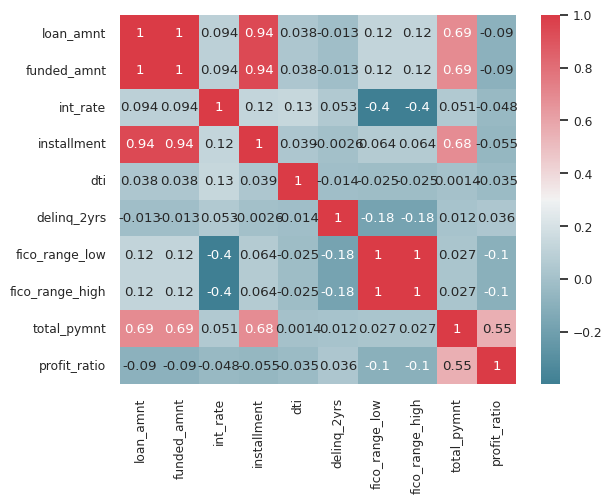

In [40]:
# prompt: print a heatmap of correlated variables in accepted

corr = accepted.corr()

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 10, as_cmap=True))

plt.show()

In [41]:
# Drop Highly Correlated Values

accepted = accepted.drop('loan_amnt', axis=1)
accepted = accepted.drop('installment', axis=1)
accepted = accepted.drop('total_pymnt', axis=1)
accepted = accepted.drop('fico_range_high', axis=1)

<ipython-input-42-97dbf8169570>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = accepted.corr()


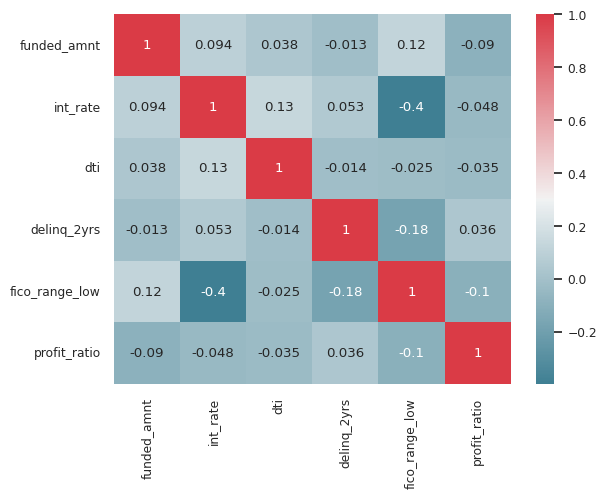

In [42]:
corr = accepted.corr()

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 10, as_cmap=True))

plt.show()

In [43]:
# look at data

accepted.head()



,id,funded_amnt,term,int_rate,grade,emp_length,home_ownership,loan_status,purpose,dti,delinq_2yrs,fico_range_low,profit_ratio
0,68407277,3600.0,36 months,13.99,C,10+ years,MORTGAGE,Fully Paid,debt_consolidation,5.91,0.0,675.0,1.228257
1,68355089,24700.0,36 months,11.99,C,10+ years,MORTGAGE,Fully Paid,small_business,16.06,1.0,715.0,1.039662
2,68341763,20000.0,60 months,10.78,B,10+ years,MORTGAGE,Fully Paid,home_improvement,10.78,0.0,695.0,1.135296
3,66310712,35000.0,60 months,14.85,C,10+ years,MORTGAGE,Current,debt_consolidation,17.06,0.0,785.0,0.898972
4,68476807,10400.0,60 months,22.45,F,3 years,MORTGAGE,Fully Paid,major_purchase,25.37,1.0,695.0,1.128894


In [44]:
# drop unnecessary features

accepted = accepted.drop('id', axis=1)

In [45]:
accepted.head()

,funded_amnt,term,int_rate,grade,emp_length,home_ownership,loan_status,purpose,dti,delinq_2yrs,fico_range_low,profit_ratio
0,3600.0,36 months,13.99,C,10+ years,MORTGAGE,Fully Paid,debt_consolidation,5.91,0.0,675.0,1.228257
1,24700.0,36 months,11.99,C,10+ years,MORTGAGE,Fully Paid,small_business,16.06,1.0,715.0,1.039662
2,20000.0,60 months,10.78,B,10+ years,MORTGAGE,Fully Paid,home_improvement,10.78,0.0,695.0,1.135296
3,35000.0,60 months,14.85,C,10+ years,MORTGAGE,Current,debt_consolidation,17.06,0.0,785.0,0.898972
4,10400.0,60 months,22.45,F,3 years,MORTGAGE,Fully Paid,major_purchase,25.37,1.0,695.0,1.128894


In [46]:
accepted.purpose.value_counts()

debt_consolidation    594793
credit_card           242358
home_improvement       72312
other                  62426
major_purchase         22838
medical                12668
car                    10506
small_business          9767
vacation                7416
moving                  7169
house                   5706
renewable_energy         593
wedding                   10
educational                1
Name: purpose, dtype: int64

In [47]:
accepted.loan_status.value_counts()

Fully Paid            482595
Current               419550
Charged Off           129187
Late (31-120 days)     10879
In Grace Period         4227
Late (16-30 days)       2104
Default                   21
Name: loan_status, dtype: int64

In [48]:
accepted.home_ownership.value_counts()

MORTGAGE    513043
RENT        414192
OWN         121169
ANY            156
NONE             3
Name: home_ownership, dtype: int64

In [49]:
accepted.grade.value_counts()

C    305122
B    300684
A    210771
D    143323
E     63885
F     18676
G      6102
Name: grade, dtype: int64

In [50]:
# Function to bin employment length
def categorize_emp_length(emp_length):
    if emp_length == '10+ years':
        return '10+ years'
    elif emp_length == '< 1 year':
        return '< 1 year'
    else:
        return '1-10 years'

# Apply the function to the 'emp_length' column
accepted['emp_length'] = accepted['emp_length'].apply(categorize_emp_length)

# Convert 'emp_length' to a categorical type
accepted['emp_length'] = pd.Categorical(accepted['emp_length'], categories=['< 1 year', '1-10 years', '10+ years'])

# Display the first few rows of the dataframe to verify changes
accepted.head()

,funded_amnt,term,int_rate,grade,emp_length,home_ownership,loan_status,purpose,dti,delinq_2yrs,fico_range_low,profit_ratio
0,3600.0,36 months,13.99,C,10+ years,MORTGAGE,Fully Paid,debt_consolidation,5.91,0.0,675.0,1.228257
1,24700.0,36 months,11.99,C,10+ years,MORTGAGE,Fully Paid,small_business,16.06,1.0,715.0,1.039662
2,20000.0,60 months,10.78,B,10+ years,MORTGAGE,Fully Paid,home_improvement,10.78,0.0,695.0,1.135296
3,35000.0,60 months,14.85,C,10+ years,MORTGAGE,Current,debt_consolidation,17.06,0.0,785.0,0.898972
4,10400.0,60 months,22.45,F,1-10 years,MORTGAGE,Fully Paid,major_purchase,25.37,1.0,695.0,1.128894


In [51]:
# prompt: bin the purpose variable, debt_consolidation, credit_card as its own category, the rest all labeled as other

accepted['purpose'] = accepted['purpose'].apply(lambda x: 'debt_consolidation' if x=='debt_consolidation' else 'credit_card' if x=='credit_card' else 'other')


In [52]:
accepted.head()

,funded_amnt,term,int_rate,grade,emp_length,home_ownership,loan_status,purpose,dti,delinq_2yrs,fico_range_low,profit_ratio
0,3600.0,36 months,13.99,C,10+ years,MORTGAGE,Fully Paid,debt_consolidation,5.91,0.0,675.0,1.228257
1,24700.0,36 months,11.99,C,10+ years,MORTGAGE,Fully Paid,other,16.06,1.0,715.0,1.039662
2,20000.0,60 months,10.78,B,10+ years,MORTGAGE,Fully Paid,other,10.78,0.0,695.0,1.135296
3,35000.0,60 months,14.85,C,10+ years,MORTGAGE,Current,debt_consolidation,17.06,0.0,785.0,0.898972
4,10400.0,60 months,22.45,F,1-10 years,MORTGAGE,Fully Paid,other,25.37,1.0,695.0,1.128894


In [53]:
# Check missing values
accepted.isnull().sum()

funded_amnt        12
term               12
int_rate           12
grade              12
emp_length          0
home_ownership     12
loan_status        12
purpose             0
dti               868
delinq_2yrs        12
fico_range_low     12
profit_ratio       12
dtype: int64

In [54]:
# prompt: drop row with missing values
accepted = accepted.dropna()

In [55]:
# prompt: bin loan status as either fully paid, default/charged off, or late

# Function to bin late loans
def categorize_loan_status(input):
    if input == 'Fully Paid':
        return 'Fully Paid'
    elif input == 'Charged Off' or input == 'Default':
        return 'Default/Charged Off'
    else:
        return 'Late'

# prompt: Remove those that have current in the loan status from accepted df
accepted = accepted[accepted['loan_status'] != 'Current']

# Apply the function to the 'loan_status' column
accepted['loan_status'] = accepted['loan_status'].apply(categorize_loan_status)

# Convert 'loan_status' to a categorical type
accepted['loan_status'] = pd.Categorical(accepted['loan_status'], categories=['Fully Paid', 'Default/Charged Off', 'Late'])

# Display the first few rows of the dataframe to verify changes
accepted.head()

<ipython-input-55-588ff466fd97>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accepted['loan_status'] = accepted['loan_status'].apply(categorize_loan_status)


,funded_amnt,term,int_rate,grade,emp_length,home_ownership,loan_status,purpose,dti,delinq_2yrs,fico_range_low,profit_ratio
0,3600.0,36 months,13.99,C,10+ years,MORTGAGE,Fully Paid,debt_consolidation,5.91,0.0,675.0,1.228257
1,24700.0,36 months,11.99,C,10+ years,MORTGAGE,Fully Paid,other,16.06,1.0,715.0,1.039662
2,20000.0,60 months,10.78,B,10+ years,MORTGAGE,Fully Paid,other,10.78,0.0,695.0,1.135296
4,10400.0,60 months,22.45,F,1-10 years,MORTGAGE,Fully Paid,other,25.37,1.0,695.0,1.128894
5,11950.0,36 months,13.44,C,1-10 years,RENT,Fully Paid,debt_consolidation,10.20,0.0,690.0,1.147192


In [56]:
# prompt: unique entries in loan status

accepted['loan_status'].value_counts()


Fully Paid             482414
Default/Charged Off    129171
Late                    17190
Name: loan_status, dtype: int64

In [57]:
# What percent of fully paid loan status generate losses

fully_paid = accepted[accepted['loan_status'] == 'Fully Paid']
num_fully_paid_with_zero_profit = fully_paid[fully_paid['profit_ratio'] < 1].shape[0]
percent_fully_paid_with_zero_profit = num_fully_paid_with_zero_profit / fully_paid.shape[0] * 100
print(f"{percent_fully_paid_with_zero_profit:.2f}% of fully paid loan status have 0 for profit.")


0.00% of fully paid loan status have 0 for profit.


In [58]:
# prompt: Create a function to drop the outliers

def drop_outliers(df, features):
  """
  Drops outliers from a dataframe based on a list of features.

  Args:
      df (pd.DataFrame): The dataframe containing the data.
      features (list): A list of features to check for outliers.

  Returns:
      pd.DataFrame: The dataframe with outliers removed.
  """

  for feature in features:
    # Calculate the interquartile range (IQR)
    IQR = df[feature].quantile(0.75) - df[feature].quantile(0.25)

    # Calculate the lower and upper bounds
    lower_bound = df[feature].quantile(0.25) - 1.5 * IQR
    upper_bound = df[feature].quantile(0.75) + 1.5 * IQR

    # Drop rows outside the bounds
    df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]

  return df

# Use the function to drop outliers from the 'funded_amnt' and 'interest_rate' features
accepted = drop_outliers(accepted, ['funded_amnt', 'int_rate'])


In [59]:
# prompt: standardize the numeric features on the same scale

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to the numeric features
numeric_features = accepted[['funded_amnt', 'int_rate']]
scaler.fit(numeric_features)

# Transform the numeric features
accepted[['funded_amnt', 'int_rate']] = scaler.transform(numeric_features)


In [60]:
# prompt: one hot encoding for cat variables

accepted = pd.get_dummies(accepted, columns=['home_ownership', 'purpose', 'emp_length', 'term', 'grade'], dtype=int)



In [61]:
# prompt: print head of accepted

print(accepted.head())


   funded_amnt  int_rate loan_status    dti  delinq_2yrs  fico_range_low  \
0    -1.253294  0.349257  Fully Paid   5.91          0.0           675.0   
1     1.201034 -0.112086  Fully Paid  16.06          1.0           715.0   
2     0.654336 -0.391199  Fully Paid  10.78          0.0           695.0   
4    -0.462326  2.300739  Fully Paid  25.37          1.0           695.0   
5    -0.282031  0.222387  Fully Paid  10.20          0.0           690.0   

   profit_ratio  home_ownership_ANY  home_ownership_MORTGAGE  \
0      1.228257                   0                        1   
1      1.039662                   0                        1   
2      1.135296                   0                        1   
4      1.128894                   0                        1   
5      1.147192                   0                        0   

   home_ownership_NONE  ...  emp_length_10+ years  term_ 36 months  \
0                    0  ...                     1                1   
1                 

<ipython-input-62-833744f4fe7d>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(accepted.corr(), annot=True)


<Axes: >

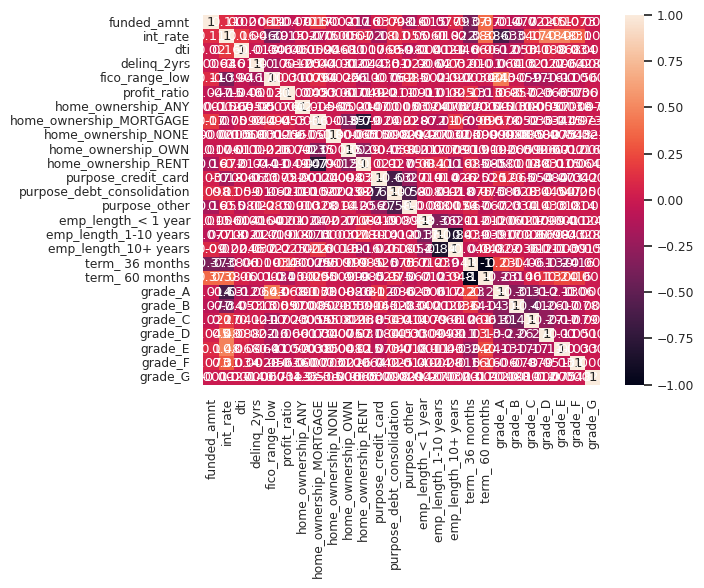

In [62]:
# prompt: print a heatmap for correlated variables

# Create a heatmap of the correlation matrix
sns.heatmap(accepted.corr(), annot=True)

In [63]:
# prompt: what are the datatypes of the features

accepted.dtypes


funded_amnt                    float64
int_rate                       float64
loan_status                   category
dti                            float64
delinq_2yrs                    float64
fico_range_low                 float64
profit_ratio                   float64
home_ownership_ANY               int64
home_ownership_MORTGAGE          int64
home_ownership_NONE              int64
home_ownership_OWN               int64
home_ownership_RENT              int64
purpose_credit_card              int64
purpose_debt_consolidation       int64
purpose_other                    int64
emp_length_< 1 year              int64
emp_length_1-10 years            int64
emp_length_10+ years             int64
term_ 36 months                  int64
term_ 60 months                  int64
grade_A                          int64
grade_B                          int64
grade_C                          int64
grade_D                          int64
grade_E                          int64
grade_F                  

In [64]:
# prompt: remove loan_status


accepted = accepted.drop('loan_status', axis=1)


In [65]:
# prompt: Add a feature to accepted where if it has a profit ratio greater than or equal to 1 then it is a 1 and if it is less than 1 then it is a 0

accepted['profitable'] = np.where(accepted['profit_ratio'] >= 1, 1, 0)

accepted = accepted.drop('profit_ratio', axis=1)

print(accepted.head())


   funded_amnt  int_rate    dti  delinq_2yrs  fico_range_low  \
0    -1.253294  0.349257   5.91          0.0           675.0   
1     1.201034 -0.112086  16.06          1.0           715.0   
2     0.654336 -0.391199  10.78          0.0           695.0   
4    -0.462326  2.300739  25.37          1.0           695.0   
5    -0.282031  0.222387  10.20          0.0           690.0   

   home_ownership_ANY  home_ownership_MORTGAGE  home_ownership_NONE  \
0                   0                        1                    0   
1                   0                        1                    0   
2                   0                        1                    0   
4                   0                        1                    0   
5                   0                        0                    0   

   home_ownership_OWN  home_ownership_RENT  ...  term_ 36 months  \
0                   0                    0  ...                1   
1                   0                    0  ...     

In [66]:
# prompt: split train test set, set 'profitable'' as target, the rest as features, perform logistic regression, train on a 3-fold cv, fit on the test set, get the accuracy and auc score for the test set

# Split the data into train and test sets
X = accepted.drop('profitable', axis=1)
y = accepted['profitable']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a LogisticRegression model
model = LogisticRegression(random_state=42)

# Perform 3-fold cross-validation on the training set
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print(f"3-fold CV accuracy: {scores.mean():.3f} +/- {scores.std():.3f}")

# Fit the model on the entire training set
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate the accuracy and AUC score for the test set
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

print(f"Test set accuracy: {accuracy:.3f}")
print(f"Test set AUC: {auc:.3f}")


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

3-fold CV accuracy: 0.790 +/- 0.000
Test set accuracy: 0.788
Test set AUC: 0.526


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


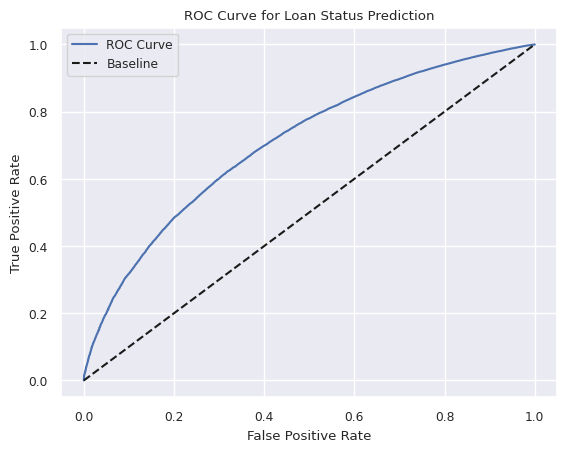

In [67]:
# prompt: draw the auc chart

# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC Curve')

# Plot the baseline
plt.plot([0, 1], [0, 1], 'k--', label='Baseline')

# Add labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Loan Status Prediction')

# Add legend
plt.legend()


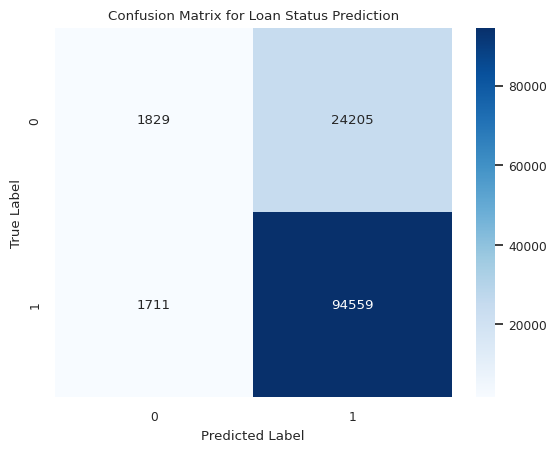

In [68]:
# prompt: Plot confusion index

# Predict the labels for the test set
y_pred = model.predict(X_test)

# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Add labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Loan Status Prediction')

# Show the plot
plt.show()


In [69]:
# prompt: Print classification report

# Predict the labels for the test set
y_pred = model.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.07      0.12     26034
           1       0.80      0.98      0.88     96270

    accuracy                           0.79    122304
   macro avg       0.66      0.53      0.50    122304
weighted avg       0.74      0.79      0.72    122304



### This recall for predicting losses is terrible
We will make an effort to even out the data

In [70]:
accepted.head()

,funded_amnt,int_rate,dti,delinq_2yrs,fico_range_low,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OWN,home_ownership_RENT,...,term_ 36 months,term_ 60 months,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,profitable
0,-1.253294,0.349257,5.91,0.0,675.0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,1
1,1.201034,-0.112086,16.06,1.0,715.0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,1
2,0.654336,-0.391199,10.78,0.0,695.0,0,1,0,0,0,...,0,1,0,1,0,0,0,0,0,1
4,-0.462326,2.300739,25.37,1.0,695.0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,1
5,-0.282031,0.222387,10.20,0.0,690.0,0,0,0,0,1,...,1,0,0,0,1,0,0,0,0,1


In [71]:
# prompt: What proportion of entries have 'profitable' == 1

profitable_count = accepted[accepted['profitable'] == 1].shape[0]
total_count = accepted.shape[0]
proportion = profitable_count / total_count
print(f"Proportion of entries with 'profitable' == 1: {proportion:.2%}")


Proportion of entries with 'profitable' == 1: 78.83%


In [72]:
# prompt: How many profitable entries == 0

loss_count = accepted[accepted['profitable'] == 0].shape[0]
print(f"Number of entries with 'profitable' == 0: {loss_count}")


Number of entries with 'profitable' == 0: 129465


In [73]:
# Create new dataframes and stack them to even out exposure to bad loans and good loans

accepted_profit = accepted[accepted['profitable'] >= 1]
accepted_profit_sample = accepted_profit.sample(n=129465)
accepted_loss = accepted[accepted['profitable'] < 1]
accepted_loss_sample = accepted_loss.sample(n=129465)
accepted_stack = pd.concat([accepted_loss_sample, accepted_profit_sample], axis=0)


In [74]:
# prompt: How many entries are profitable vs how many arent

accepted_stack['profitable'].value_counts()


0    129465
1    129465
Name: profitable, dtype: int64

In [75]:
# prompt: split train test set, set 'profitable'' as target, the rest as features, perform logistic regression, train on a 3-fold cv, fit on the test set, get the accuracy and auc score for the test set

# Split the data into train and test sets
X = accepted_stack.drop('profitable', axis=1)
y = accepted_stack['profitable']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a LogisticRegression model
model = LogisticRegression(random_state=42)

# Perform 3-fold cross-validation on the training set
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print(f"3-fold CV accuracy: {scores.mean():.3f} +/- {scores.std():.3f}")

# Fit the model on the entire training set
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate the accuracy and AUC score for the test set
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

print(f"Test set accuracy: {accuracy:.3f}")
print(f"Test set AUC: {auc:.3f}")


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

3-fold CV accuracy: 0.651 +/- 0.003
Test set accuracy: 0.654
Test set AUC: 0.655


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [76]:
# Predict the labels for the test set
y_pred = model.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.67      0.66     25784
           1       0.66      0.64      0.65     26002

    accuracy                           0.65     51786
   macro avg       0.65      0.65      0.65     51786
weighted avg       0.65      0.65      0.65     51786



A lot better f1 score for bad loans

In [77]:
# 1. Import DecisionTreeClassifier, Train-Test-Split, and Accuracy Score

# 2. Split dataset into 70% train, 30% test
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# 3. Instantiate dt, set 'criterion' to 'gini'
dt = DecisionTreeClassifier(criterion='gini', random_state=1)

# 4. Fit dt to the training set
dt.fit(X_train,y_train)

# 5. Predict test-set labels
y_pred_dt = dt.predict(X_test)

# 6. Evaluate Performance
print(f"Accuracy of Predicition (Decision Tree): {round(accuracy_score(y_test, y_pred_dt)*100,2)}%")

Accuracy of Predicition (Decision Tree): 56.93%


In [78]:
# Split data into 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y,
test_size=0.3,
stratify=y,
random_state=42)

# Instantiate a random forests classifier
rf = RandomForestClassifier(n_estimators=25, bootstrap = True, max_features = 'sqrt', min_samples_leaf = 5, criterion='gini', random_state=42)

# Fit 'rf' to the training set
rf.fit(X_train, y_train)

# Predict the test set labels 'y_pred'
y_pred_rf = rf.predict(X_test)

# Output the accuracy of our prediction
print(f"Accuracy of Random Forest Classifier is {round(accuracy_score(y_test, y_pred_rf)*100,2)}%")

Accuracy of Random Forest Classifier is 65.0%


In [79]:
# Import models and utility functions

# Split data into 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# # Instantiate an "fool" classification-tree 'fool'
fool = DecisionTreeClassifier(max_depth=1, criterion='gini', min_samples_leaf = 5, splitter = "random")

# Instantiate an AdaBoost classifier 'adab_clf'
adb_clf = AdaBoostClassifier(estimator=fool, n_estimators=25, learning_rate=.3, random_state=42)

# Fit 'adb_clf' to the training set
adb_clf.fit(X_train, y_train)

# Predict the test data
y_pred_ada = adb_clf.predict(X_test)

In [80]:
print(f'Decision Tree Accuracy: {round(accuracy_score(y_test, y_pred_dt)*100,2)}%')
print(f'Random Forest Accuracy: {round(accuracy_score(y_test, y_pred_rf)*100,2)}%')
print(f'Adaptive Boosting Accuracy: {round(accuracy_score(y_test, y_pred_ada)*100,2)}%')

Decision Tree Accuracy: 56.93%
Random Forest Accuracy: 65.0%
Adaptive Boosting Accuracy: 65.21%


In [81]:
# Ensure all column names in X_train and X_test are string type and do not contain [, ] or <
X_train.columns = X_train.columns.str.replace('[\[\]<>]', '', regex=True)
X_test.columns = X_test.columns.str.replace('[\[\]<>]', '', regex=True)

# Instantiate the XGBoost classifier with updated and optimized parameters
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,    # Increase number of trees for more robust learning
    subsample=0.8,       # Use 80% of the data for each tree to prevent overfitting
    colsample_bytree=0.8, # Use 80% of features for each tree to prevent overfitting
    learning_rate=0.1,   # Set a learning rate for convergence
    random_state=1       # Ensure reproducibility
)

# Fit the classifier to the training data
xgb_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb = xgb_clf.predict(X_test)

# Calculate and print the accuracy of the model
accuracy = accuracy_score(y_test, y_pred_xgb)
print(f'Extreme Gradient Boosting Accuracy: {round(accuracy*100,2)}%')


Extreme Gradient Boosting Accuracy: 66.17%


XGBoost is a little better. Still poor performance.

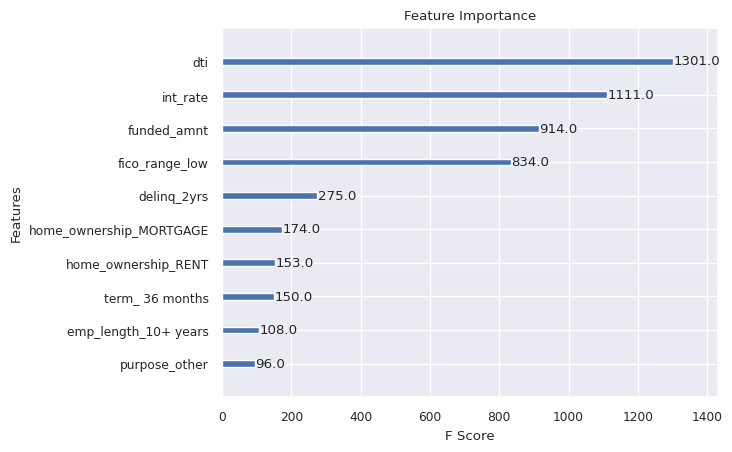

In [82]:
# Plot feature importance
xgb.plot_importance(xgb_clf, max_num_features=10)
plt.title("Feature Importance")
plt.ylabel('Features')
plt.xlabel('F Score')
plt.show()

DTI is still the most important feature

## Penalized Logistic Regression (L1 penalty) to Classify Loan Profitability

We further implement the logistic regression classifier with a lasso (L1) penalty for predicting profitability on the accepted loans

In [83]:
# prompt: cross-validate logistic regression for optimal lasso penalty

# Split the data into training and testing sets
X = accepted_stack.drop('profitable', axis=1)
y = accepted_stack['profitable']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Standardize features for lasso penalty
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# Define the model
log_lasso = LogisticRegression(penalty='l1', solver='liblinear')

# Lambda grid for penalties
grid = dict()
grid['C'] = arange(0, 0.002, 0.0002)

# Initialize GridSearchCV with 5 fold CV for hyperparameter tuning
grid_search = GridSearchCV(log_lasso, grid, cv=5, scoring='accuracy')

# Fit GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Evaluate the results of our cross-validation
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

optimal_C = grid_search.best_params_['C']


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1160, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/

Best parameters: {'C': 0.0018000000000000002}
Best cross-validation score: 0.6515660741828813


Now we fit a logistic regression model with the tuned hyperparameter.

In [84]:
# Define the model
log_lasso = LogisticRegression(penalty='l1', solver='liblinear', C = optimal_C)

# Fit the model
log_lasso.fit(X_train_scaled, y_train)

# Check coefs
print("Coefficients:", log_lasso.coef_)

# Make predictions on the test set
y_pred = log_lasso.predict(X_test_scaled)

# Calculate accuracy and AUC score for the test set
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

print("Test set accuracy:", accuracy)
print("Test set AUC score:", auc)

Coefficients: [[-0.04566589 -0.48453476 -0.12673747 -0.00440351  0.11789612  0.
   0.11416883  0.          0.         -0.04868973  0.          0.
  -0.00602181  0.         -0.01096056  0.02649794  0.         -0.27665307
   0.10505658  0.         -0.04162716  0.          0.02201939  0.03941122
   0.        ]]
Test set accuracy: 0.6549839725022206
Test set AUC score: 0.6550537023417587


Here, we visualize the regularization pathway and coefficients with the lasso penalty.

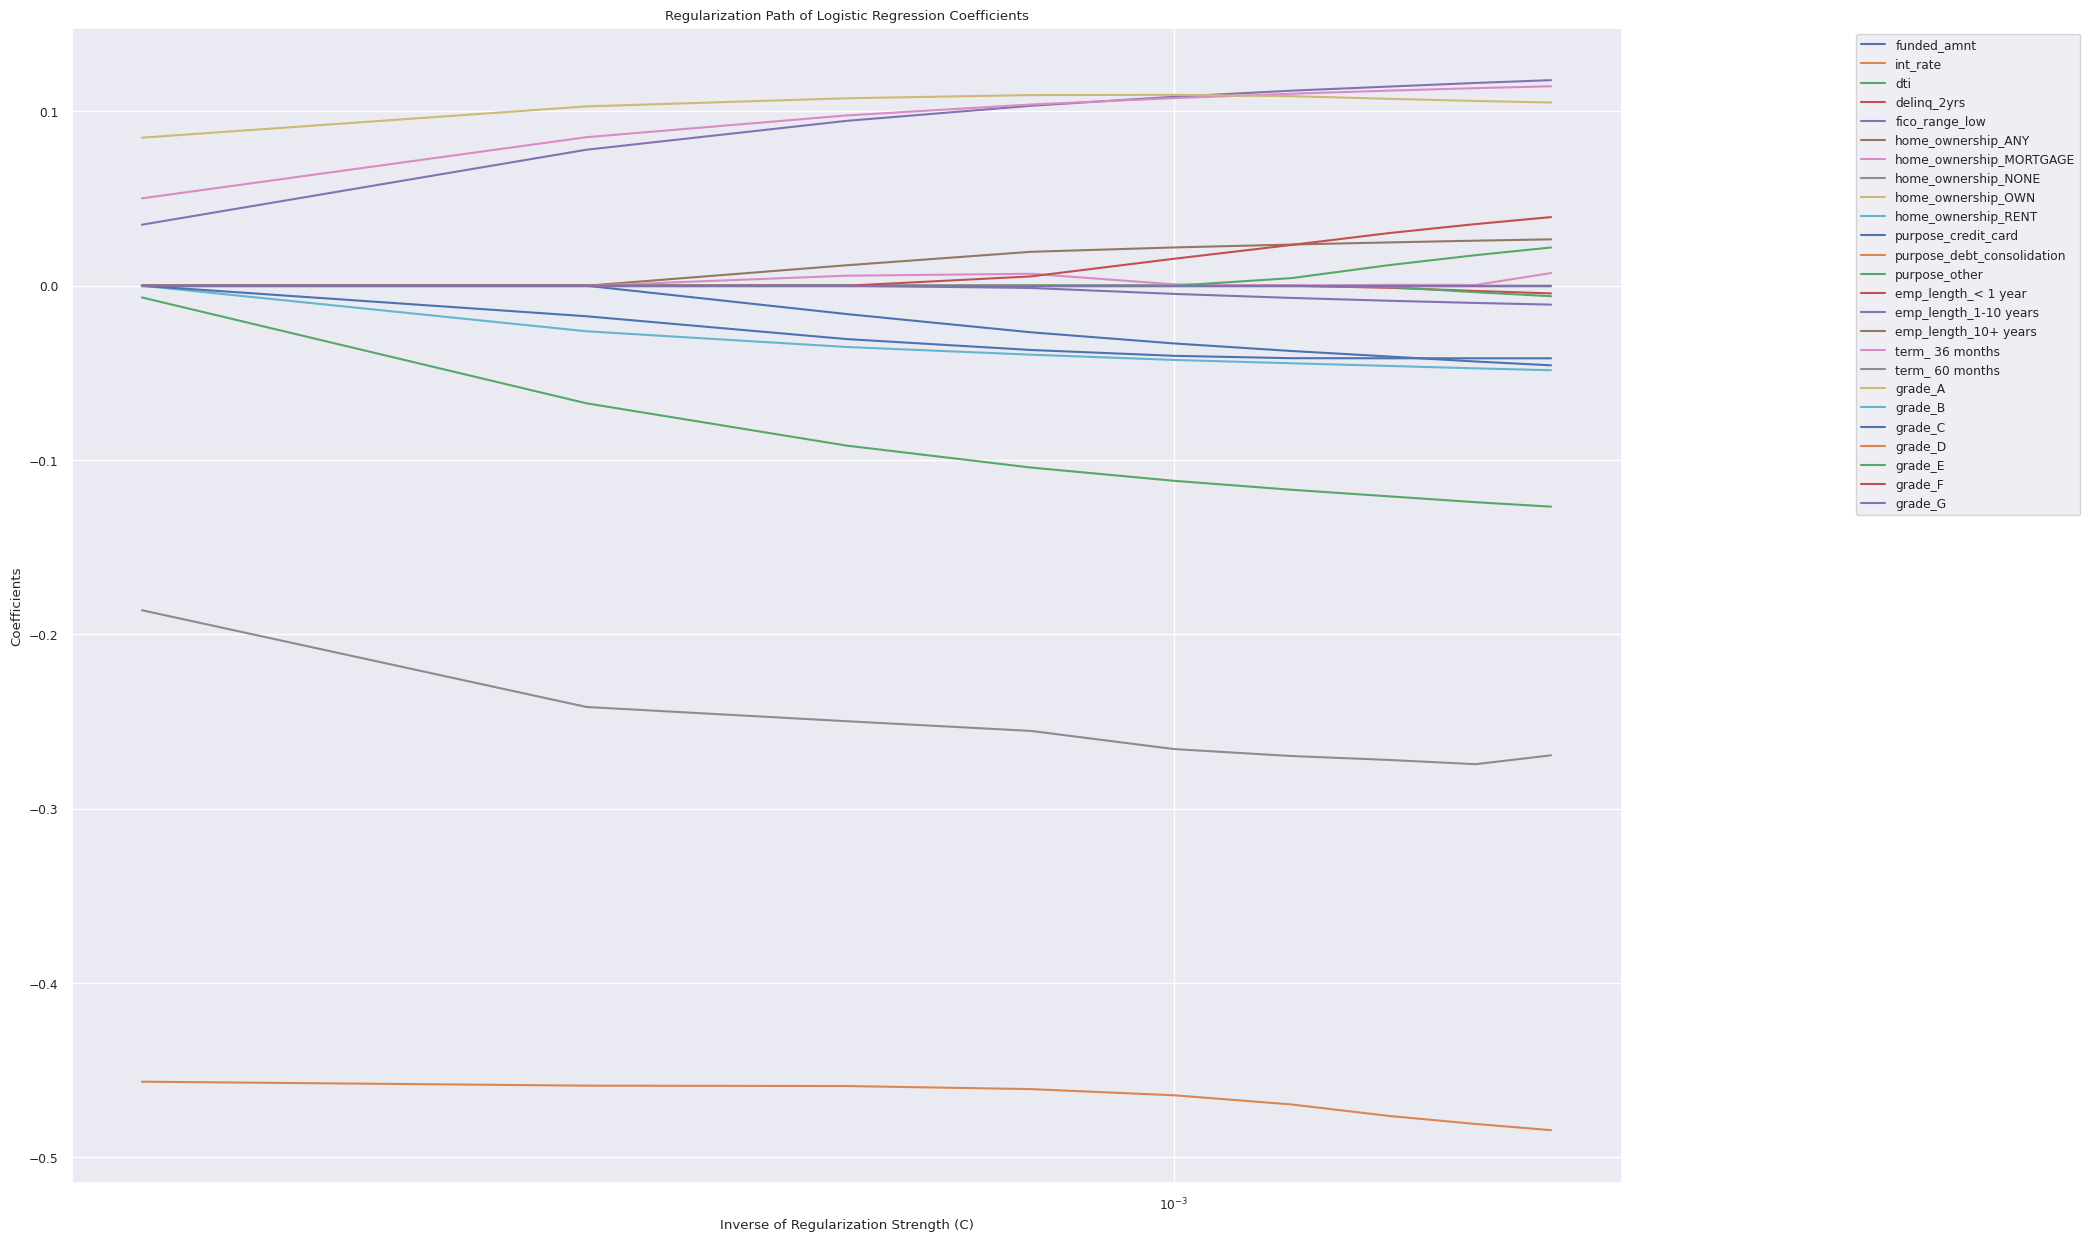

In [85]:
# Range of regularization strengths as per cross-validation above - C denotes inverse of regularization strength (smaller C -> higher penalty)
C_values = arange(0.0002, 0.002, 0.0002)

# Initialize a list to store the coefficients
coefficients = []

for C in C_values:
    logreg = LogisticRegression(penalty='l1', C=C, solver='liblinear', random_state=42)
    logreg.fit(X_train_scaled, y_train)
    coefficients.append(logreg.coef_[0])

# Convert the list of coefficients into a 2D numpy array
coefficients = np.array(coefficients)

# Plot the regularization path
plt.figure(figsize=(20, 15))
for i in range(coefficients.shape[1]):
    plt.plot(C_values, coefficients[:, i], label=accepted.columns[i])

plt.xscale('log')
plt.xlabel('Inverse of Regularization Strength (C)')
plt.ylabel('Coefficients')
plt.title('Regularization Path of Logistic Regression Coefficients')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.show()

Observations from LASSO regularization path on loan profitability

(+) grade A, 36 months term, homeowners

(-) grade D, 60 month term, DTI

1. Longer term loans seem to be less profitable. This is evidenced by the negative coefficient of the `term-60 months` dummy categorical feature. The coefficient of this term never shrinks to zero regardless of regularization strength in the lasso, so it is highly significant for predicting profitability.
2. Grade D borrowers are the least profitable - the grade D coefficient is highly signficant.
3. Ideal borrowers for maximum profitability are grade A, borrowing for a shorter (36 month) term, and are homeowners with low DTI.